# DS SC22x
 
### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [1]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [2]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

In [4]:
df.isna().sum()

game_id              0
game_event_id        0
player_name          0
period               0
minutes_remaining    0
seconds_remaining    0
action_type          0
shot_type            0
shot_zone_basic      0
shot_zone_area       0
shot_zone_range      0
shot_distance        0
loc_x                0
loc_y                0
shot_made_flag       0
game_date            0
htm                  0
vtm                  0
season_type          0
dtype: int64

In [5]:
df.dtypes

game_id               int64
game_event_id         int64
player_name          object
period                int64
minutes_remaining     int64
seconds_remaining     int64
action_type          object
shot_type            object
shot_zone_basic      object
shot_zone_area       object
shot_zone_range      object
shot_distance         int64
loc_x                 int64
loc_y                 int64
shot_made_flag        int64
game_date            object
htm                  object
vtm                  object
season_type          object
dtype: object

In [6]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season


In [7]:
# 불필요한 컬럼 제외
df = df.drop(['game_id', 'game_event_id', 'player_name'], axis=1)

In [9]:
# profile = ProfileReport(df, title="Pandas Profiling Report").to_notebook_iframe()

# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [10]:
target = 'shot_made_flag'

# 기준 모델 설정
df[target].value_counts(normalize=True)
# 기준 모델 정확도 : 0.552692

0    0.552692
1    0.447308
Name: shot_made_flag, dtype: float64

## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 2014-15 ~ 2015-16 시즌을 test set으로 만듭니다. NBA 시즌은 10월에 시작해서 6월에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [11]:
test = df[(df['game_date'] >= '2014-10-01') & (df['game_date'] < '2016-07-01')]
train = df.drop(test.index, axis=0)

test.shape

(1826, 16)

## 1.3 새로운 feature를 만드세요

> 최소 1개 이상의 새로운 feature를 만드세요. 아래의 리스트를 사용하셔도 되고 스스로의 아이디어로 만들어 주셔도 괜찮습니다.
>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [12]:
test['homecourt_advantage'] = test['htm'] == 'LAL'
train['homecourt_advantage'] = train['htm'] == 'LAL'
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,homecourt_advantage
0,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,True
1,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,False
2,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season,False
3,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season,False
4,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season,False


## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [13]:
# 훈련 / 검증 셋으로 분리
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((23096, 17), (5775, 17), (1826, 17))

In [14]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [15]:
pipe = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['action_type', 'shot_type',
                                     'shot_zone_basic', 'shot_zone_area',
                                     'shot_zone_range', 'game_date', 'htm',
                                     'vtm', 'season_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indic...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decreas

## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [16]:
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.6356709956709957


## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [17]:
print('테스트 정확도', pipe.score(X_test, y_test))

테스트 정확도 0.6615553121577218


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

In [18]:
tp = 36
tn = 85
fp = 58
fn = 8
total = tp + tn + fp + fn

### a) Accuracy score를 계산하세요

In [19]:
# 정확도
correct_predictions = tp + tn
correct_predictions / total

0.6470588235294118

### b) Precision score를 계산하세요 

In [20]:
# 정밀도
positives = tp + fp
precision = tp/positives
precision

0.3829787234042553

### c) Recall score를 계산하세요

In [21]:
# 재현율
real_positives = tp + fn
recall = tp / real_positives
recall

0.8181818181818182

In [22]:
# Advanced Goals
# >**3점**을 획득하기 위해선 아래의 **"모든 조건"**을 만족해야합니다. 
# - **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.
# - `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.
# - 최소 3개의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.
# - `feature importance`를 계산하고 시각화 해주세요.

In [27]:
# 새로운 feature 만들기
# 코비 브라이언트 생년월일 : 1978년 8월 23일
df['homecourt_advantage'] = df['htm'] == 'LAL' # 홈 어드벤티지 여부
df['total_seconds_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining'] # 슛 당시 해당 쿼터에서 남은 시간(초)

df['overtime'] = (df['period'] - 4).apply(lambda x: 0 if x < 0 else x) # 연장전 쿼터 수(period 5 이상인 경우)
df['stdtime'] = df['period'] - df['overtime'] # 정규 쿼터(최대 4)
df['run_time'] = df['stdtime']*12*60 + df['overtime']*5*60 + (12*60 - df['total_seconds_remaining']) # 슛 시점까지 경기에서 플레이한 시간(초)

df['kobe_age'] = (round((pd.to_datetime(df['game_date']) - pd.to_datetime('1978-08-23')) / pd.Timedelta(days=365))).apply(lambda x: int(x)) # 경기 당시 코비의 나이

df.head()

,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,homecourt_advantage,total_seconds_remaining,overtime,run_time,kobe_age,stdtime
0,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,True,42,0,1398,18,1
1,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,False,608,0,1552,18,2
2,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season,False,517,0,1643,18,2
3,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season,False,394,0,1766,18,2
4,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season,False,327,0,1833,18,2


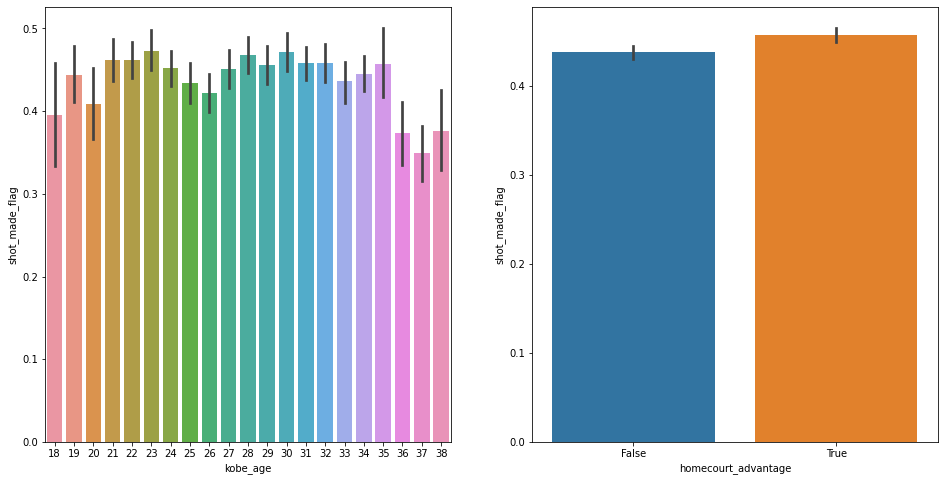

In [42]:
# feature와 target 관계 시각화(나이와 득점 수, 홈 어드벤티지와 득점 수의 관계)
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(ax=axes[0], x='kobe_age', y='shot_made_flag', data=df)
sns.barplot(ax=axes[1], x='homecourt_advantage', y='shot_made_flag', data=df)

In [30]:
# 모델 최적화
test = df[(df['game_date'] >= '2014-10-01') & (df['game_date'] < '2016-07-01')]
train = df.drop(test.index, axis=0)

train.shape, test.shape

((28871, 22), (1826, 22))

In [31]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [36]:
from scipy.stats import randint, uniform


pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)

params = {
    'randomforestclassifier__max_depth': [5, 15, None],
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']
}

clf = GridSearchCV(
    pipe, 
    param_grid=params, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.9min finished


In [43]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('F1: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200}
F1:  0.5873822493704001


In [37]:
pipe = clf.best_estimator_

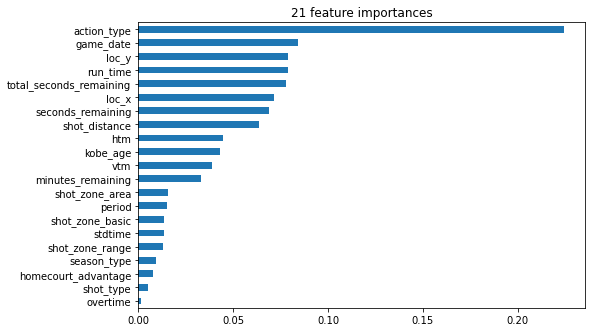

In [45]:
# 특성 중요도 계산 및 시각화
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = len(rf.feature_importances_)
plt.figure(figsize=(8,n/4))
plt.title(f'{n} feature importances')
importances.sort_values()[-n:].plot.barh();